In [1]:
import pkg_resources as pkg
path = pkg.resource_filename(__name__, "../")

import os 
os.chdir( path )

/tmp/ipykernel_3458100/2665741738.py:2: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  path = pkg.resource_filename(__name__, "../")


In [28]:
import torch
from pytorch_lightning import LightningModule

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt

import numpy as np 
import seaborn as sns
import pandas as pd

from physioex.data import SleepPhysionet, TimeDistributedModule
from physioex.train.networks import TinySleepNet, ContrTinySleepNet

In [3]:
dataset = SleepPhysionet(version = "2018", use_cache = True)
dataset.split(fold = 0)
sequence_length = 3
batch_size = 32
datamodule = TimeDistributedModule(dataset = dataset, sequence_lenght = sequence_length, batch_size = batch_size, transform = None, target_transform = None)

ccl_model_path = "models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=0-epoch=15-step=77670-val_acc=0.79.ckpt"
scl_model_path = "models/SCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=0-epoch=18-step=93864-val_acc=0.79.ckpt"

2023-12-23 10:19:36.867 | INFO     | physioex.data.utils:read_cache:11 - Reading chache from temp/sleep_physionet_2018.pkl


## PCA components of the Similarity Model

### Extracting the latent space projections from the similarity model

In [31]:
model = ContrTinySleepNet.load_from_checkpoint(scl_model_path).eval()

train_projections = []
y_train_true = []
y_train_pred = []

# scorri tutti i batch del train dataloader 
for batch in datamodule.train_dataloader():
    inputs, y_true = batch

    y_train_true.append(y_true)
    
    projections, y_pred = model(inputs.to(model.device))
    y_train_pred.append(y_pred.cpu().detach().numpy())
    train_projections.append(projections.cpu().detach().numpy())

    del projections, y_pred

y_train_true = np.concatenate(y_train_true).reshape(-1)
train_projections = np.concatenate(train_projections).reshape(y_train_true.shape[0], -1)
y_train_pred = np.concatenate(y_train_pred).reshape(-1, 5)

print(train_projections.shape)
print(y_train_true.shape)
print(y_train_pred.shape)

(489381, 32)
(489381,)
(489381, 5)


### Plotting the first 2 PCA components

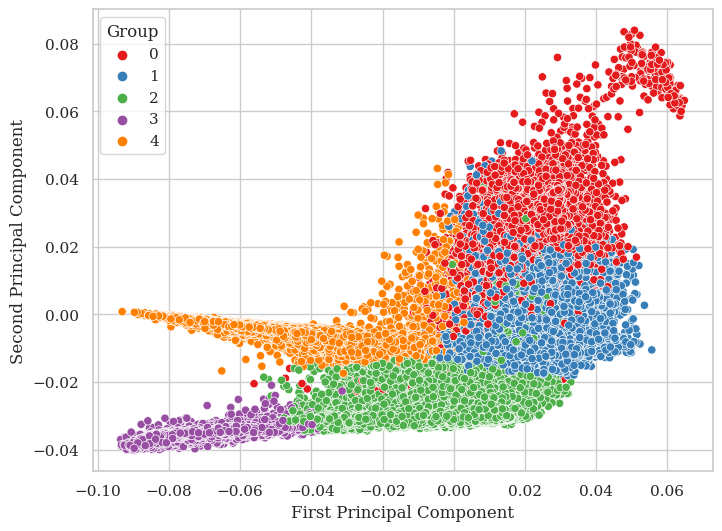

In [32]:
preds = np.argmax(y_train_pred, axis = 1)
true_indx = np.where(y_train_true == preds)[0]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(train_projections[true_indx, :])
true_positive = y_train_true[true_indx]

df = pd.DataFrame({
    'First Principal Component': train_projections[true_indx, 0],
    'Second Principal Component': train_projections[true_indx, 1],
    'Group': true_positive
})

plt.figure(figsize=(8, 6))

# Utilizza seaborn.scatterplot
sns.scatterplot(data=df, x='First Principal Component', y='Second Principal Component', hue='Group', palette='Set1')

plt.show()
plt.close()

### Assessing the latent space quality measuring the ARI

/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureW

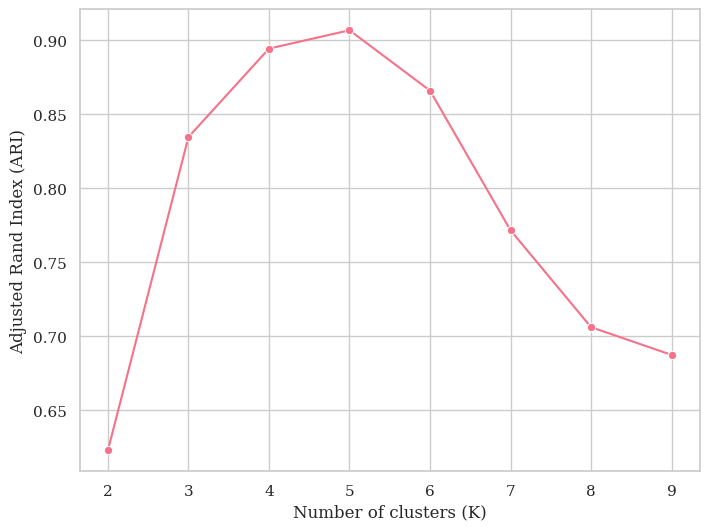

In [34]:
K_values = range(2, 10)

# Lista per memorizzare i risultati ARI
ari_values = []

for K in K_values:
    # Esegui K-Means con il valore corrente di K
    kmeans = KMeans(n_clusters=K, random_state=0).fit(train_projections[true_indx, :])
    
    # Calcola l'ARI confrontando le assegnazioni di K-Means con i true_positive
    ari = adjusted_rand_score(true_positive, kmeans.labels_)
    
    # Memorizza il risultato
    ari_values.append(ari)

# Crea un DataFrame dai risultati
results = pd.DataFrame({
    'Number of clusters (K)': K_values,
    'Adjusted Rand Index (ARI)': ari_values
})

# Plotta i risultati con Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=results, x='Number of clusters (K)', y='Adjusted Rand Index (ARI)', marker='o')
plt.show()
plt.close()

## Repeating the same experiment with the Standard Model

In [26]:
model = TinySleepNet.load_from_checkpoint(ccl_model_path).eval()

train_projections = []
y_train_true = []
y_train_pred = []

# scorri tutti i batch del train dataloader 
for batch in datamodule.train_dataloader():
    inputs, y_true = batch

    y_train_true.append(y_true)
    
    projections, y_pred = model.encode(inputs.to(model.device))
    y_train_pred.append(y_pred.cpu().detach().numpy())
    train_projections.append(projections.cpu().detach().numpy())

    del projections, y_pred

y_train_true = np.concatenate(y_train_true).reshape(-1)
train_projections = np.concatenate(train_projections).reshape(y_train_true.shape[0], -1)
y_train_pred = np.concatenate(y_train_pred).reshape(-1, 5)

print(train_projections.shape)
print(y_train_true.shape)
print(y_train_pred.shape)

(489381, 128)
(489381,)
(489381, 5)


/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


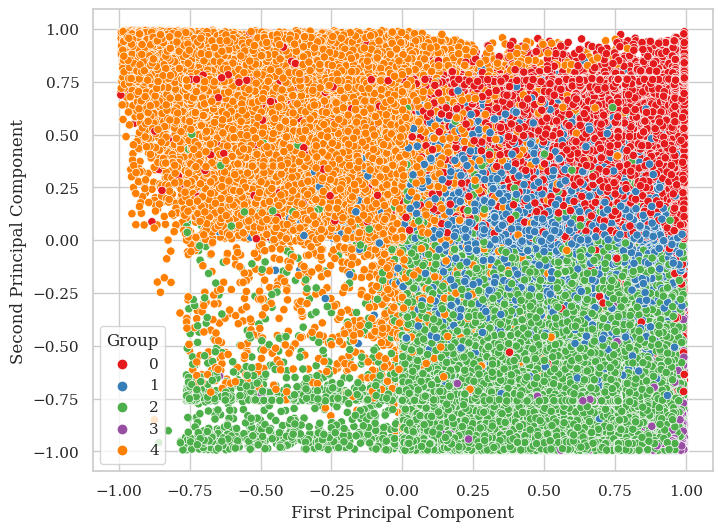

In [27]:
preds = np.argmax(y_train_pred, axis = 1)
true_indx = np.where(y_train_true == preds)[0]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(train_projections[true_indx, :])
true_positive = y_train_true[true_indx]

df = pd.DataFrame({
    'First Principal Component': train_projections[true_indx, 0],
    'Second Principal Component': train_projections[true_indx, 1],
    'Group': true_positive
})

plt.figure(figsize=(8, 6))

# Utilizza seaborn.scatterplot
sns.scatterplot(data=df, x='First Principal Component', y='Second Principal Component', hue='Group', palette='Set1')

plt.show()
plt.close()

/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureW

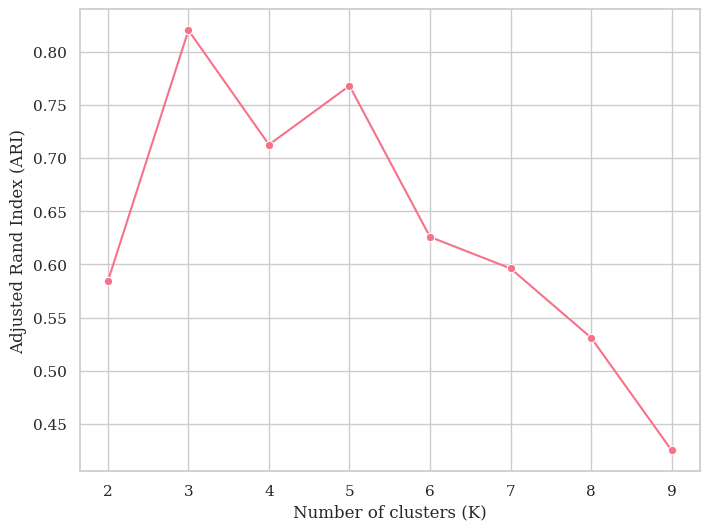

In [30]:
# Valori di K da testare
K_values = range(2, 10)

# Lista per memorizzare i risultati ARI
ari_values = []

for K in K_values:
    # Esegui K-Means con il valore corrente di K
    kmeans = KMeans(n_clusters=K, random_state=0).fit(train_projections[true_indx, :])
    
    # Calcola l'ARI confrontando le assegnazioni di K-Means con i true_positive
    ari = adjusted_rand_score(true_positive, kmeans.labels_)
    
    # Memorizza il risultato
    ari_values.append(ari)

# Crea un DataFrame dai risultati
results = pd.DataFrame({
    'Number of clusters (K)': K_values,
    'Adjusted Rand Index (ARI)': ari_values
})

# Plotta i risultati con Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=results, x='Number of clusters (K)', y='Adjusted Rand Index (ARI)', marker='o')
plt.show()
plt.close()